In [1]:
import re
import os
from collections import Counter
import logging
import time
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

import pymc3

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [3]:
# parameters
FILTER_STEM = True
TRAIN_PORTION = 0.8
RANDOM_STATE = 7

In [4]:
dataset_path = os.path.join("..","input" ,os.listdir("../input")[0])
df = pd.read_csv(dataset_path, encoding="ISO-8859-1", names=["target", "ids", "date", "flag", "user", "text"])

In [5]:
%%time
decode_map = {0: -1, 2: 0, 4: 1}
df.target = df.target.apply(lambda x: decode_map[x])

CPU times: user 604 ms, sys: 116 ms, total: 720 ms
Wall time: 717 ms


In [6]:
%%time
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
def filter_stopwords(text):
    text = re.sub("@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+", ' ', str(text).lower()).strip()
    if FILTER_STEM:
        return " ".join([stemmer.stem(token) for token in text.split() if token not in stop_words])
    else:
        return " ".join([token for token in text.split() if token not in stop_words])
df.text = df.text.apply(filter_stopwords)

CPU times: user 4min 12s, sys: 840 ms, total: 4min 13s
Wall time: 4min 13s


In [7]:
%%time
vectorizer = TfidfVectorizer()
word_frequency = vectorizer.fit_transform(df.text)

CPU times: user 20.4 s, sys: 1 s, total: 21.4 s
Wall time: 21.4 s


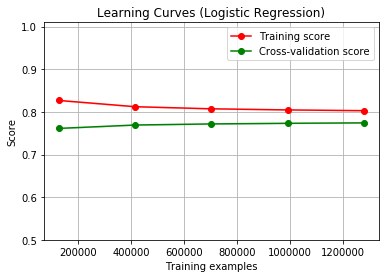

CPU times: user 1.59 s, sys: 1.02 s, total: 2.61 s
Wall time: 11min 20s


In [9]:
%%time
title = r"Learning Curves (Logistic Regression)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = LogisticRegression(random_state=0, solver='saga', multi_class='multinomial')
plot_learning_curve(estimator, title, word_frequency, df.target, (0.5, 1.01), cv=cv, n_jobs=8)

plt.show()